## 1. Import Required Libraries
Import torch, torchvision, matplotlib, and other required libraries.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

## 2. Load and Preprocess MNIST Dataset
Download the MNIST dataset using torchvision, apply necessary transforms, and create DataLoader objects.

In [17]:
batch_size = 128
image_size = 28
channels = 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## 3. Define Generator Network
Implement the Generator class using torch.nn.Module, specifying layers and forward method.

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, image_size * image_size * channels),
            nn.Tanh()
        )
        self.latent_dim = latent_dim
    def forward(self, z):
        out = self.model(z)
        out = out.view(z.size(0), channels, image_size, image_size)
        return out

## 4. Define Discriminator Network
Implement the Discriminator class using torch.nn.Module, specifying layers and forward method.

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * channels, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

## 5. Initialize Networks and Optimizers
Instantiate generator and discriminator models, define loss function, and set up optimizers.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## 6. Training Loop for GAN
Write the training loop to alternately train the discriminator and generator, logging losses.

In [21]:
# --- GAN Training Loop with improvements ---
import copy

d_losses = []
g_losses = []
fixed_z = torch.randn(16, latent_dim).to(device)  # For consistent evaluation
sample_images = []

epochs = 30
for epoch in range(epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)
        # 1. Train Discriminator (multiple steps)
        for _ in range(1):  # You can increase this for more D steps
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            outputs_real = discriminator(real_imgs)
            outputs_fake = discriminator(fake_imgs.detach())
            d_loss_real = criterion(outputs_real, real_labels)
            d_loss_fake = criterion(outputs_fake, fake_labels)
            d_loss = d_loss_real + d_loss_fake
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
        d_loss_epoch += d_loss.item()
        # 2. Train Generator (multiple steps)
        for _ in range(2):  # You can increase this for more G steps
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            outputs_fake = discriminator(fake_imgs)
            g_loss = criterion(outputs_fake, real_labels)
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()
        g_loss_epoch += g_loss.item()
    d_losses.append(d_loss_epoch / len(train_loader))
    g_losses.append(g_loss_epoch / len(train_loader))
    # 3. Save generated images with fixed z for each epoch
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(fixed_z).cpu() * 0.5 + 0.5
        sample_images.append(fake_samples)
    generator.train()
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss_epoch/len(train_loader):.4f}  G_loss: {g_loss_epoch/len(train_loader):.4f}")
# 4. Save model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(generator.state_dict(), 'checkpoints/generator.pth')
torch.save(discriminator.state_dict(), 'checkpoints/discriminator.pth')

Epoch [1/30]  D_loss: 1.0379  G_loss: 0.8985
Epoch [2/30]  D_loss: 1.1954  G_loss: 0.9732
Epoch [3/30]  D_loss: 1.2423  G_loss: 0.9186
Epoch [4/30]  D_loss: 1.2851  G_loss: 0.8537
Epoch [5/30]  D_loss: 1.3010  G_loss: 0.8341
Epoch [6/30]  D_loss: 1.3100  G_loss: 0.8251
Epoch [7/30]  D_loss: 1.3145  G_loss: 0.8215
Epoch [8/30]  D_loss: 1.3136  G_loss: 0.8182
Epoch [9/30]  D_loss: 1.3128  G_loss: 0.8206
Epoch [10/30]  D_loss: 1.3145  G_loss: 0.8201
Epoch [11/30]  D_loss: 1.3100  G_loss: 0.8263
Epoch [12/30]  D_loss: 1.3081  G_loss: 0.8259
Epoch [13/30]  D_loss: 1.3080  G_loss: 0.8284
Epoch [14/30]  D_loss: 1.3034  G_loss: 0.8314
Epoch [15/30]  D_loss: 1.3009  G_loss: 0.8387
Epoch [16/30]  D_loss: 1.2978  G_loss: 0.8435
Epoch [17/30]  D_loss: 1.2913  G_loss: 0.8481
Epoch [18/30]  D_loss: 1.2889  G_loss: 0.8556
Epoch [19/30]  D_loss: 1.2846  G_loss: 0.8619
Epoch [20/30]  D_loss: 1.2806  G_loss: 0.8648
Epoch [21/30]  D_loss: 1.2755  G_loss: 0.8750
Epoch [22/30]  D_loss: 1.2734  G_loss: 0.88

## 7. Generate and Visualize Samples
Use the trained generator to produce fake MNIST images and visualize them using matplotlib.

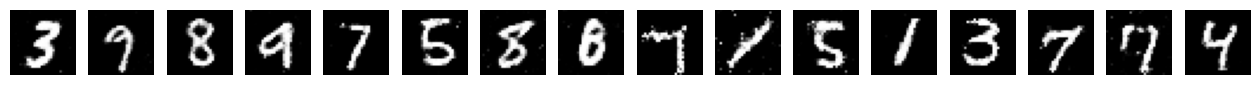

In [22]:
generator.eval()
z = torch.randn(16, latent_dim).to(device)
fake_imgs = generator(z).cpu().detach()
fake_imgs = fake_imgs * 0.5 + 0.5  # Denormalize
fig, axes = plt.subplots(1, 16, figsize=(16, 2))
for i in range(16):
    axes[i].imshow(fake_imgs[i][0], cmap='gray')
    axes[i].axis('off')
plt.show()

## 8. Calculate FID Score
We will use the `torchmetrics` library to calculate the FID (Fréchet Inception Distance) score between generated images and real MNIST images. If not installed, run `pip install torchmetrics`.

In [23]:
# If torchmetrics is not installed, uncomment the next line:
# !pip install torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid
from torchmetrics.image.inception import InceptionScore


# Prepare real and fake images for FID calculation
fid = FrechetInceptionDistance(feature=64).to(device)
inception = InceptionScore().to(device)


# Get a batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:128].to(device)
real_imgs = real_imgs.repeat(1, 3, 1, 1)  # Convert to 3 channels for FID

# Generate a batch of fake images
z = torch.randn(128, latent_dim).to(device)
fake_imgs = generator(z)
fake_imgs = fake_imgs.repeat(1, 3, 1, 1)  # Convert to 3 channels for FID

real_imgs_uint8 = (real_imgs * 255).clamp(0, 255).to(torch.uint8)
fake_imgs_uint8 = (fake_imgs * 255).clamp(0, 255).to(torch.uint8)

fid.update(real_imgs_uint8, real=True)
fid.update(fake_imgs_uint8, real=False)
fid_score = fid.compute().item()
print(f"FID score: {fid_score:.2f}")

inception.update(fake_imgs_uint8)
inception_score = inception.compute()
print(f"Inception Score: {inception_score[0]:.4f}")



FID score: 0.01
Inception Score: 2.1057


## Loss Curve Visualization
Discriminator와 Generator의 loss 변화를 그래프로 확인합니다.

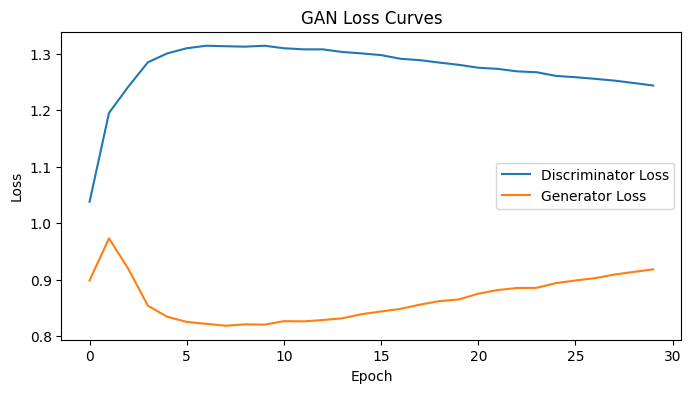

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss Curves')
plt.show()

## Fixed z로 생성된 이미지 시각화
에폭별로 고정된 z에서 생성된 이미지를 시각화하여 발전 과정을 확인합니다.

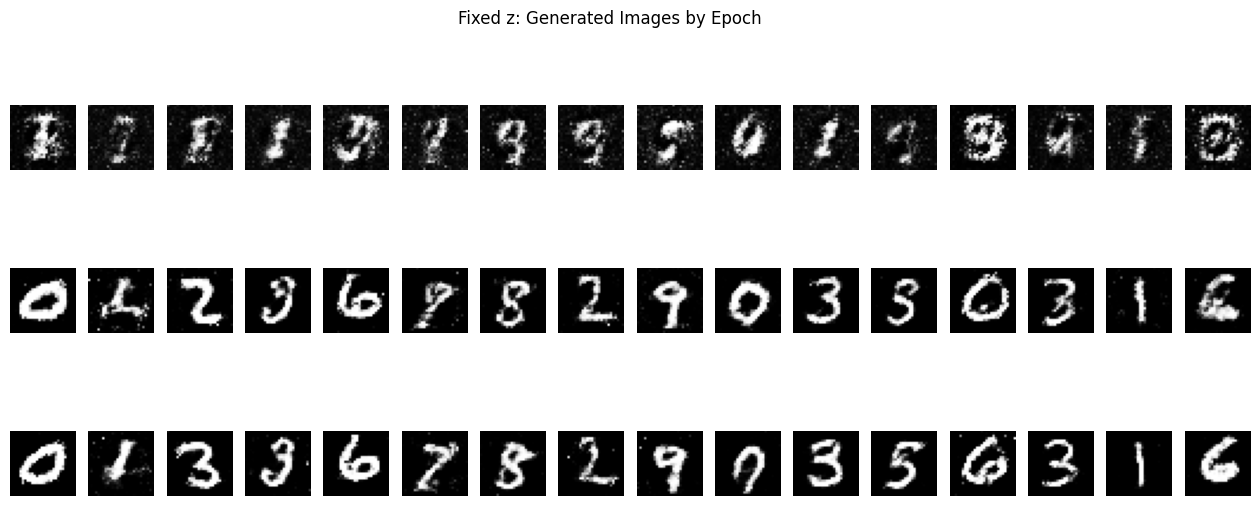

In [27]:
# 에폭별로 고정 z에서 생성된 이미지 시각화
n_epochs_to_show = len(sample_images)//10
plt.figure(figsize=(16, 2 * n_epochs_to_show))
for i in range(n_epochs_to_show):
    imgs = sample_images[10*i]
    for j in range(16):
        plt.subplot(n_epochs_to_show, 16, i * 16 + j + 1)
        plt.imshow(imgs[j][0], cmap='gray')
        plt.axis('off')
plt.suptitle('Fixed z: Generated Images by Epoch')
plt.show()